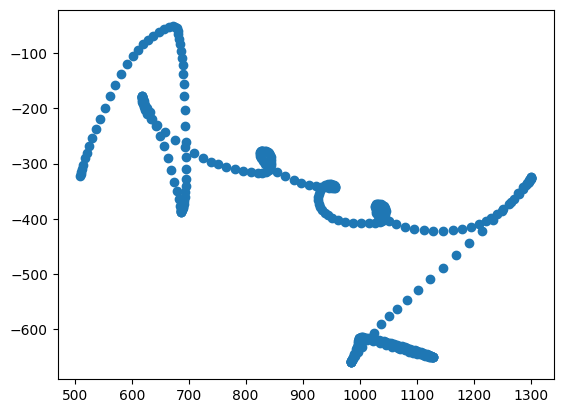

In [1]:
import numpy as np
import json

from plotting import *

from preprocess import preprocess

with open("data/signatures.txt") as f:
	signatures = json.load(f)
	np_signatures = np.array(signatures)

signals = [preprocess(np_signature) for np_signature in np_signatures]
plot_signals(signals)

signal = signals[0]

In [2]:
# !pip install --upgrade scipy==1.8.0
import scipy
print(scipy.__version__) # 1.8.0

1.8.0


In [3]:
print(len(signal.position),len(signal.velocity))

330 329


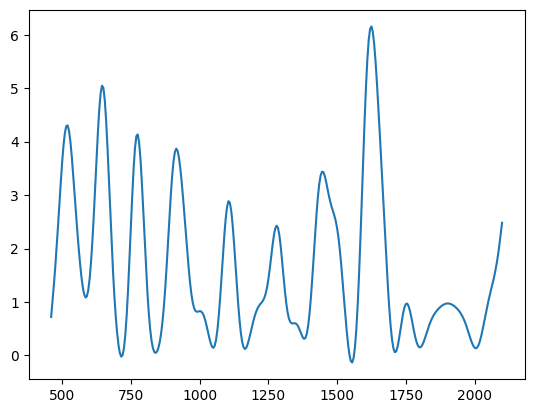

In [4]:
import matplotlib.pyplot as plt

plt.plot(signal.time[:-1],signal.speed)

['Point(role=2,idx=5,time=485.0,speed=2.4178092629565575,angle=5.029705699827004)', 'Point(role=3,idx=12,time=520.0,speed=4.303226723319164,angle=5.18903250005721)']
['Point(role=1,idx=0,time=460.0,speed=0.7180295750376625,angle=3.072919332717859)', 'Point(role=2,idx=5,time=485.0,speed=2.4178092629565575,angle=5.029705699827004)', 'Point(role=3,idx=12,time=520.0,speed=4.303226723319164,angle=5.18903250005721)', 'Point(role=4,idx=17,time=545.0,speed=3.0418514569439017,angle=5.37399051818184)', 'Point(role=5,idx=25,time=585.0,speed=1.0833692013285348,angle=7.005233558991916)']
LognormalStroke(D=383.0423043497579,t_0=273.305528208328,mu=5.528454926387512,sigma=0.1424931988919755,theta_s=4.931072940160421,theta_f=5.512921001317994)


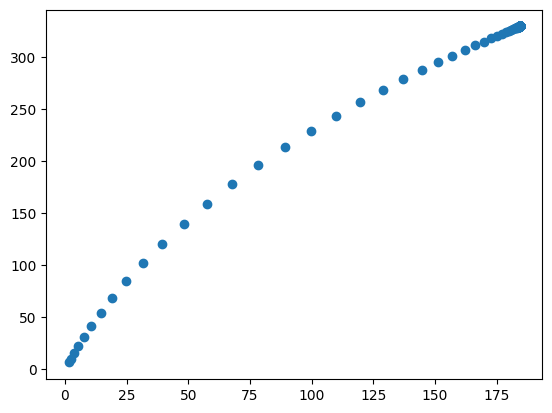

In [5]:
from speed_extract import extract_sigma_lognormal, get_point_combos, get_stroke_combos, mark_stroke_candidates

candidates=mark_stroke_candidates(signal)

candidate=candidates[0]
point_combos=get_point_combos(candidate)
point_combo = point_combos[0]
print([str(pt) for pt in point_combo])

stroke_combos = get_stroke_combos(candidate)
stroke_combo = stroke_combos[0]
print([str(pt) for pt in stroke_combo])

lognormal = extract_sigma_lognormal(point_combo,stroke_combo)
print(lognormal)
plot_signals([lognormal.signal(signal.time)])

In [6]:
np.array(1)/0

inf

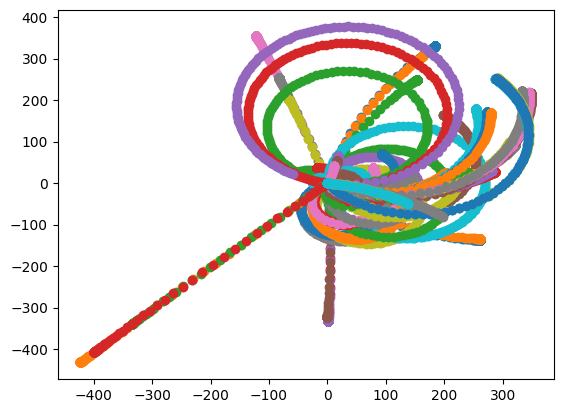

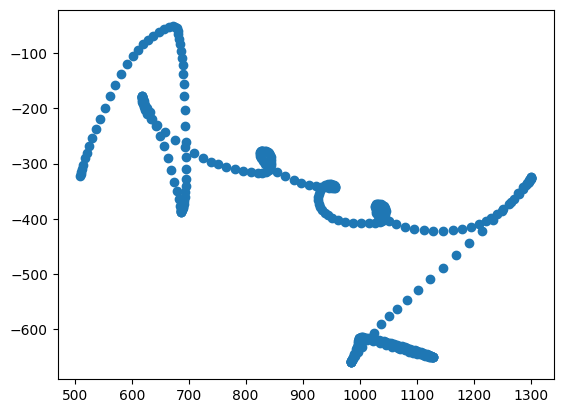

In [7]:
from speed_extract import extract_all_lognormals


lognormals = extract_all_lognormals(signal)

plot_signals([lgn.signal(signal.time) for lgn in lognormals])
plot_signals([signal])

In [8]:
from beam_search import BeamSearch
from action_plan import ActionPlan

top_k = 2
snr_threshold = 25
max_strokes = 18
search = BeamSearch(signal,top_k,snr_threshold,max_strokes)

demo_plan = ActionPlan([],signal.position[0])

suggest_plans = search.get_next_action_plans([demo_plan])


Plan making 70 plans - 0.020902156829833984
Plan sorting - 0.2314131259918213


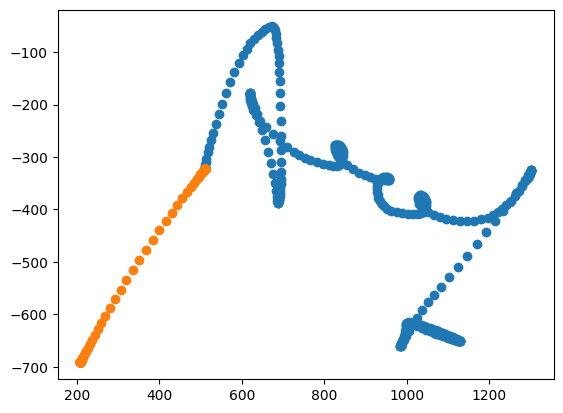

In [9]:
suggest_plan = suggest_plans[0]
plot_signals([signal,suggest_plan.signal(signal.time)])

In [10]:
out_plan = search.search()
out_signal = out_plan.signal(signal.time)

Plan making 70 plans - 0.0170290470123291
Plan sorting - 0.19719719886779785
Max. SNR: 1.295300451332422
Num. strokes: 1
Plan making 357 plans - 0.14078974723815918
Plan sorting - 1.3345074653625488
Max. SNR: 2.2887311477152332
Num. strokes: 2
Plan making 378 plans - 0.08363080024719238
Plan sorting - 1.8548181056976318
Max. SNR: 3.3586303895388276
Num. strokes: 3
Plan making 364 plans - 0.07505154609680176
Plan sorting - 2.078141689300537
Max. SNR: 4.511299766685482
Num. strokes: 4
Plan making 1604 plans - 0.3037419319152832
Plan sorting - 11.260459423065186
Max. SNR: 5.881297046032495
Num. strokes: 5
Plan making 1804 plans - 0.37277841567993164
Plan sorting - 14.708780288696289
Max. SNR: 7.634648726425817
Num. strokes: 6
Plan making 1804 plans - 0.30346059799194336
Plan sorting - 19.048742294311523
Max. SNR: 8.79667609355103
Num. strokes: 7
Plan making 1804 plans - 0.468674898147583
Plan sorting - 22.46315097808838
Max. SNR: 10.051983248753412
Num. strokes: 8
Plan making 506 plans - 

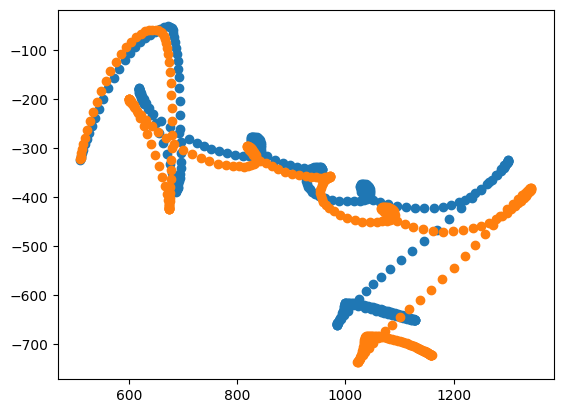

In [11]:
plot_signals([signal,out_signal])

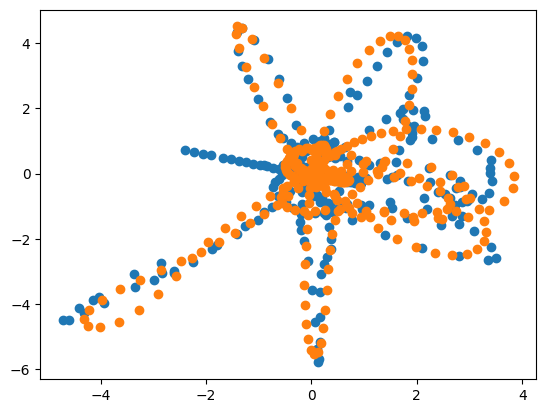

In [12]:
plot_velocities([signal,out_signal])

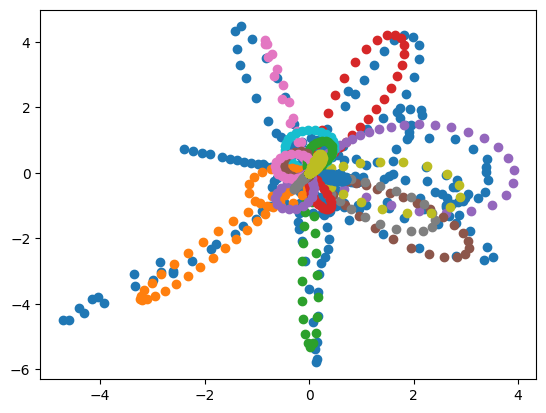

In [13]:
stroke_signals = [stroke.signal(signal.time) for stroke in out_plan.strokes]
plot_velocities([signal,*stroke_signals])

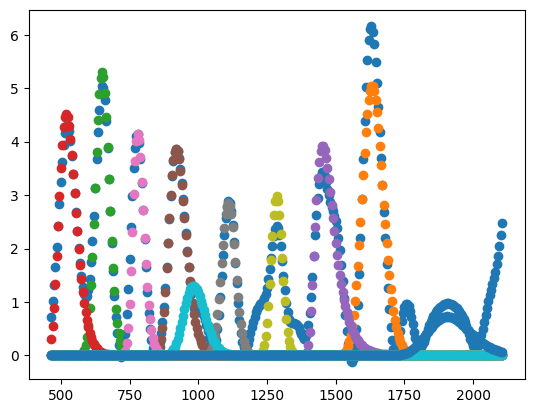

In [14]:
plot_speeds([signal,*stroke_signals[:10]])

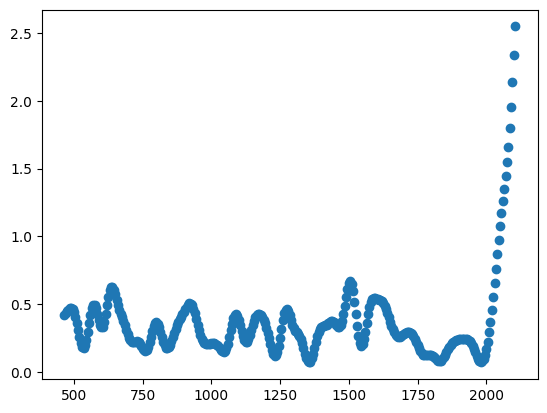

In [15]:
plot_speeds([signal - out_signal])